In [1]:
import pandas as pd
import numpy as np
# from utilities.gex_parser import parse_gex_file
import matplotlib.pyplot as plt

In [2]:
# Start with just importing the time domain module of simpeg, and a utility to plot a layered model.
import simpeg.electromagnetics.time_domain as tdem

from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
    inversion,
)

from simpeg.data_misfit import L2DataMisfit

import discretize
from discretize import TensorMesh

# Load data from .csv

In [4]:
file_path = "/Users/shekholam/Desktop/UBC/EOSC_556/Project/Data/AusAEM-WA/AusAEM_WA_Block_E_EM.csv"
df = pd.read_csv(file_path, 
                 #delim_whitespace=True,
                 delimiter=",") 
                 #sep=r'\s+', 
                 #comment='#') #delimiter="\t")#, comment='#')  # Ignore headers if marked with '#'

/var/folders/nv/3rmg65wj733gdy4gk5sxm8cc0000gn/T/ipykernel_2405/1942277806.py:2: DtypeWarning: Columns (153,154,156,171) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,


In [5]:
# take a look of the dataframe/
df.head()

,GA_Project,Job_No,Fiducial,Line,Flight,DateTime,Date_UTC,Time_UTC,What,Date_Local,...,RUNC_HM_Z_19,RUNC_HM_Z_20,RUNC_HM_Z_21,RUNC_HM_Z_22,RUNC_HM_Z_23,MA1,BMAG,TMI,IGRF,TMI_IGRF
0,100101,5002,10079,43500879,100101,20210827.01,44435.00509,20210827,719.5,20210827.1,...,3.95584,6.45271,4.14097,37.22344,2.98606,57747.00,58335.57,57744.43,57898.01,58179.42
1,100101,5002,10079,43500880,100101,20210827.01,44435.00509,20210827,720.0,20210827.0,...,4.37806,7.87759,4.43024,25.36838,2.89718,57748.45,58335.57,57745.88,57898.02,58180.87
2,100101,5002,10079,43500881,100101,20210827.01,44435.00510,20210827,720.5,20210827.0,...,4.73999,8.92172,4.52947,16.99572,2.85546,57749.54,58335.57,57746.96,57898.02,58181.94
3,100101,5002,10079,43500882,100101,20210827.01,44435.00510,20210827,721.0,20210827.0,...,5.14875,9.81910,4.50944,11.99612,2.85190,57749.98,58335.58,57747.40,57898.02,58182.38
4,100101,5002,10079,43500883,100101,20210827.01,44435.00511,20210827,721.5,20210827.0,...,5.47572,10.91546,4.44444,9.06249,2.87407,57749.75,58335.58,57747.16,57898.01,58182.15


In [6]:
# Replace invalid values (-99999999) with NaN
df.replace(-99999999, np.nan, inplace=True)
df.replace(0, np.nan, inplace=True)
# Drop rows with missing values
df.dropna(inplace=True)

In [7]:
#filter data of flight lines 101102 and 101201
df_101102 = df[df["GA_Project"] == 101102]
df_101201 = df[df["GA_Project"] == 101201]

df_101102.to_csv("flight_line_101102.csv")
df_101201.to_csv("flight_line_101201.csv")

In [8]:
# extract lat, lon, easting, northing, Z-comp LM dB/dt processed and normalised, Z-comp HM dB/dt processed and normalised, 
# Z-comp LM dB/dt relative uncertainty, Z-comp HM dB/dt relative uncerttainty

# lat, lon (WGS84)
lat=df_101102["Latitude"]
lon=df_101102["Longitude"]

# easting, northing (GDA2020 MGA Zone 50)
easting=df_101102["Easting"]
northing=df_101102["Northing"]

# z component Low Moment, High Moment 
LM_Z=df_101102.iloc[:, 65:83]*1e-12
HM_Z=df_101102.iloc[:, 83:106]*1e-12

# z component relative uncertainty Low Moment, High Moment
RUNC_LM_Z=df_101102.iloc[:, 106:124]
RUNC_HM_Z=df_101102.iloc[:, 124:147]


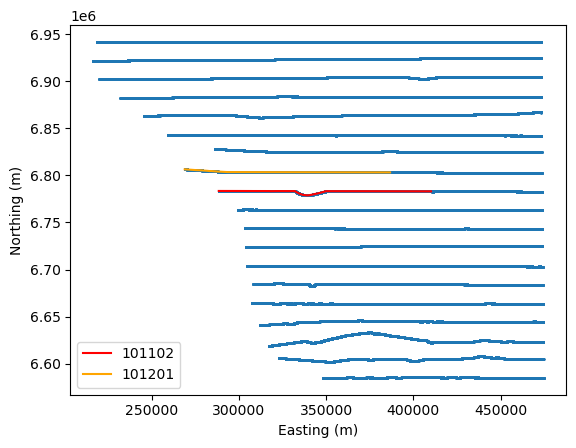

In [9]:
# plot all flight lines and selected flight lines

plt.scatter(df["Easting"], df["Northing"], s=0.5)
plt.plot(easting, northing, label="101102", c="r")
plt.plot(df_101201["Easting"], df_101201["Northing"], label="101201", c="orange")
#plt.scatter(line.UTMX, line.UTMY, s=0.5)
#plt.scatter(station.UTMX, station.UTMY, s=200, marker='*')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.legend()
plt.show()

In [10]:
# Normalize LM_Z and HM_Z by dividing by their peak values
# Provided data are normalized. 

# LM_Z_norm = LM_Z / LM_Z.max()
# HM_Z_norm = HM_Z / HM_Z.max()

# Starting with single station (sounding)

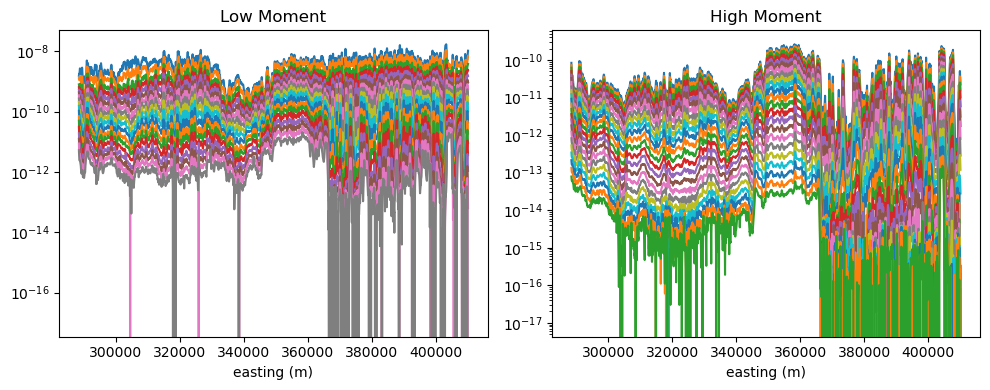

In [12]:
# look at the data
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].semilogy(easting, LM_Z)
ax[0].set_xlabel('easting (m)')
#ax[0].set_ylim(1e-5, 1e5)
ax[0].set_title('Low Moment')

ax[1].semilogy(easting, HM_Z)
ax[1].set_xlabel('easting (m)')
ax[1].set_title('High Moment')

plt.tight_layout()

In [13]:
# Select a single sounding along that line, and grab all of the data associated with that station
# Record 5999
station = df_101102[5999:6000]
station_lm_data = station.iloc[0, 65:83].to_numpy()*1e-12
#station_lm_std = station.iloc[0, 9+n_lm_gates:9+2*n_lm_gates].to_numpy()
station_hm_data = station.iloc[0, 83:106].to_numpy()*1e-12
#station_hm_std = station.iloc[0,  9+2*n_lm_gates + n_hm_gates:].to_numpy()

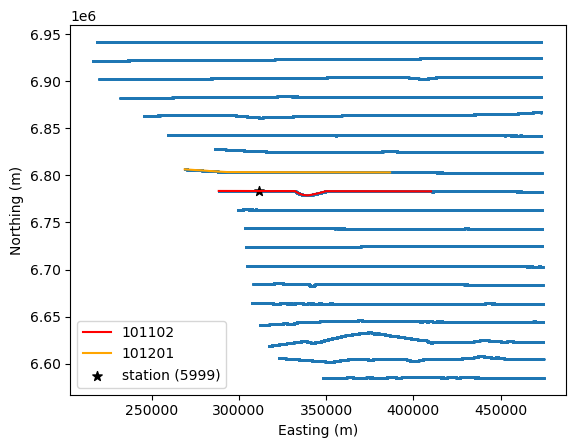

In [14]:
# show selected station
plt.scatter(df["Easting"], df["Northing"], s=0.5)
plt.plot(easting, northing, label="101102", c="r")
plt.plot(df_101201["Easting"], df_101201["Northing"], label="101201", c="orange")
plt.scatter(station["Easting"], station["Northing"], c="k", marker="*", label="station (5999)", s=50)
#plt.scatter(line.UTMX, line.UTMY, s=0.5)
#plt.scatter(station.UTMX, station.UTMY, s=200, marker='*')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.legend()
plt.show()

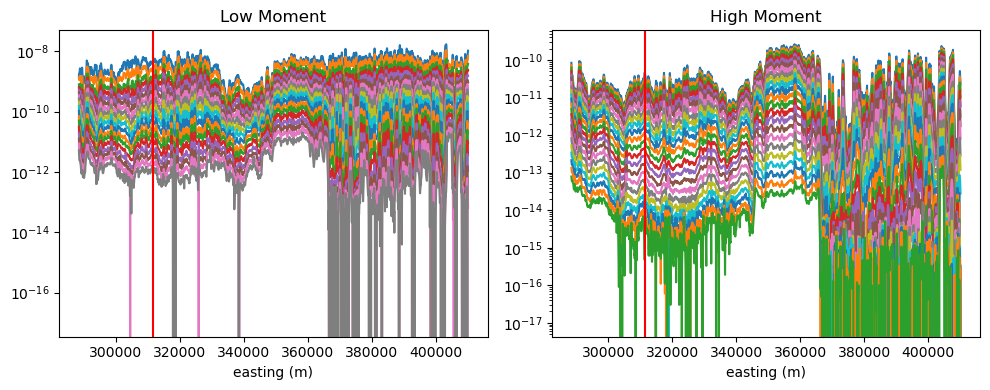

In [15]:
# look at the data
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].semilogy(easting, LM_Z)
ax[0].set_xlabel('easting (m)')
ax[0].axvline(station.iloc[0, 17], c="r")
#ax[0].set_ylim(1e-5, 1e5)
ax[0].set_title('Low Moment')

ax[1].semilogy(easting, HM_Z)
ax[1].set_xlabel('easting (m)')
ax[1].axvline(station.iloc[0, 17], c="r")
ax[1].set_title('High Moment')

plt.tight_layout()

In [16]:
# load the gate opening time for LM and HM respectively
LM_excel = "../Data/LM_times.csv"
HM_excel = "../Data/HM_times.csv"
LM_times_csv = pd.read_csv(LM_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 
HM_times_csv = pd.read_csv(HM_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 

In [17]:
# extract gate_centre (s)
LM_times = LM_times_csv["Gate Centre (s)"].to_numpy()
HM_times = HM_times_csv["Gate Centre (s)"].to_numpy()

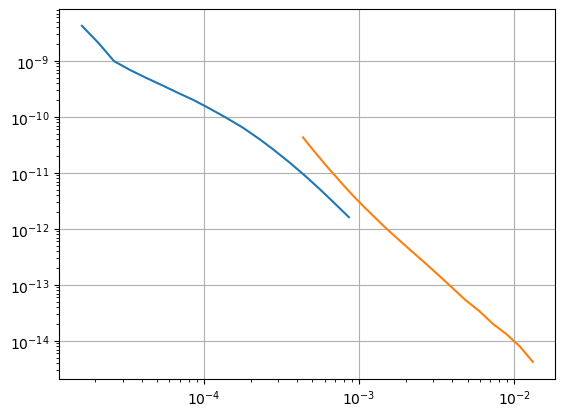

In [18]:
# plot data for single station (1999)
plt.loglog(LM_times, station_lm_data)
plt.loglog(HM_times, station_hm_data)
plt.grid()

# Setting up survey

In [20]:
LM_waveform_excel = "../Data/LM_waveform.csv"
HM_waveform_excel = "../Data/HM_waveform.csv"
LM_waveform_csv = pd.read_csv(LM_waveform_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 
HM_waveform_csv = pd.read_csv(HM_waveform_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 

In [21]:
# extract the time and form from waveform_csv 
LM_wave_time = LM_waveform_csv["Time (s)"]
LM_wave_form = LM_waveform_csv["Amplitude"]
HM_wave_time = HM_waveform_csv["Time (s)"]
HM_wave_form = HM_waveform_csv["Amplitude"]

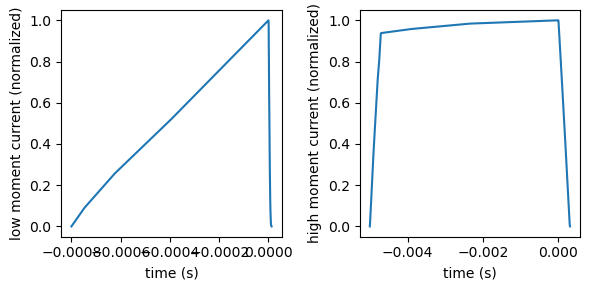

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(6,3))
ax[0].plot(LM_wave_time, LM_wave_form)
ax[0].set_ylabel("low moment current (normalized)")
ax[0].set_xlabel("time (s)")

ax[1].plot(HM_wave_time, HM_wave_form)
ax[1].set_ylabel("high moment current (normalized)")
ax[1].set_xlabel("time (s)")

plt.tight_layout()

In [23]:
# shape of the transmitter, and the offset of the receiver coil.
tx_shape = np.array([[-12.64,  -2.13,   0.  ],
       [ -6.15,  -8.59,   0.  ],
       [  5.74,  -8.59,   0.  ],
       [ 11.13,  -3.19,   0.  ],
       [ 11.13,   3.19,   0.  ],
       [  5.74,   8.59,   0.  ],
       [ -6.15,   8.59,   0.  ],
       [-12.64,   2.13,   0.  ],
       [-12.64,  -2.13,   0.  ]])
rx_offset = np.array([-13.46,   0.  ,  -2.  ]) # from data processing report

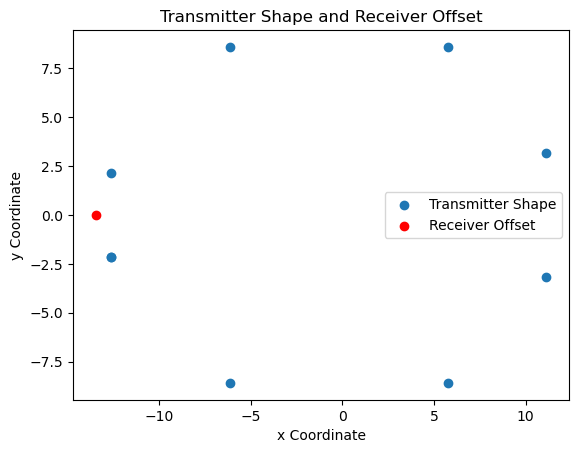

In [24]:
# Extract x and y coordinates for transmitter shape
tx_x = [point[0] for point in tx_shape]
tx_y = [point[1] for point in tx_shape]

# Scatter plot for transmitter shape
plt.scatter(tx_x, tx_y, label='Transmitter Shape')

# Scatter plot for receiver offset
plt.scatter(rx_offset[0], rx_offset[1], label='Receiver Offset', color='red')

# Add labels and legend
plt.xlabel('x Coordinate')
plt.ylabel('y Coordinate')
plt.title('Transmitter Shape and Receiver Offset')
plt.legend()

# Show the plot
plt.show()

In [25]:
# add UTM coordinates to transmitter shape and the receiver offset
# tx_loc = tx_shape + [311527.56, 6783344.30, station["GPS_Alt"].iloc[0]]
tx_loc = tx_shape + [station["Easting"].iloc[0], station["Northing"].iloc[0], station["GPS_Alt"].iloc[0]] # 17 is easting, 18 is northing, 19 is altitude of Tx loop
rx_loc = rx_offset + [station["Easting"].iloc[0], station["Northing"].iloc[0], station["GPS_Alt"].iloc[0]]
tx_area=342.0 # from data processing report

In [26]:
# Low moment:
rx_lm = tdem.receivers.PointMagneticFluxTimeDerivative(
    rx_loc, LM_times, orientation='z'
)

lm_wave = tdem.sources.PiecewiseLinearWaveform(LM_wave_time, LM_wave_form)

src_lm = tdem.sources.LineCurrent(rx_lm, tx_loc, waveform=lm_wave)

In [27]:
# high moment
rx_hm = tdem.receivers.PointMagneticFluxTimeDerivative(
    rx_loc, HM_times, orientation='z'
)

hm_wave = tdem.sources.PiecewiseLinearWaveform(HM_wave_time, HM_wave_form)

src_hm = tdem.sources.LineCurrent(rx_hm, tx_loc, waveform=hm_wave)

In [28]:
srv = tdem.Survey([src_lm, src_hm])
srv_lm = tdem.Survey(src_lm)
srv_hm = tdem.Survey(src_hm)

In [29]:
# simple forward simulation
thicknesses = [1]
conductivities = [1e0,1e-1]

In [30]:
sim = tdem.Simulation1DLayered(srv, sigma=conductivities, thicknesses=thicknesses)

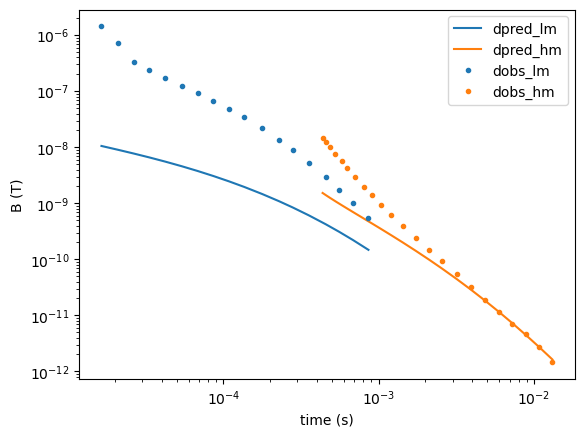

In [31]:
# sim.thicknesses = [5]
# sim.sigma = [3E-1]
pre = -sim.dpred(None)
pre_lm = pre[:18]
pre_hm = pre[18:]

plt.loglog(LM_times, pre_lm, label="dpred_lm")
plt.loglog(HM_times, pre_hm, label="dpred_hm")
plt.loglog(LM_times, station_lm_data*tx_area, color='C0', marker='.', linestyle='', label="dobs_lm")
plt.loglog(HM_times, station_hm_data*tx_area, color='C1', marker='.', linestyle='', label="dobs_hm")
plt.xlabel("time (s)")
plt.ylabel("B (T)")
plt.legend()
plt.show()

# Set up inversion for single station

In [33]:
# map
exp_map = maps.ExpMap()
exp_map * np.array([-5])

array([0.00673795])

In [34]:
# noise std? = uncertainties
station_lm_std = station.iloc[0, 147: 165].to_numpy()
station_hm_std = station.iloc[0, 165: 188].to_numpy()

In [186]:
# observed data (normalised) & relative errors 
dobs = -tx_area * np.r_[station_lm_data, station_hm_data]
rel_err = np.r_[station_lm_std, station_hm_std]*100

# Convert 'dobs' to a proper numeric array
dobs = np.array(dobs, dtype=np.float64)  # Force float64 conversion

# Ensure no NaN or infinite values
dobs = np.nan_to_num(dobs, nan=1e-10, posinf=1e-10, neginf=-1e-10)

# Convert 'rel_err' to a proper numeric array
rel_err = np.array(rel_err, dtype=np.float64)  # Ensure float64 type

# Handle NaN or invalid values
rel_err = np.nan_to_num(rel_err, nan=1e-10, posinf=1e-10, neginf=1e-10)

# 5% of the absolute value
uncertainties = 0.05 * np.abs(dobs) * np.ones(np.shape(dobs))

# rel_err = np.full(41, 0.05)

# data_container = data.Data(srv, dobs=dobs, relative_error=uncertainties) # method 2 to obtain data_object
data_container = data.Data(srv, dobs=dobs, relative_error=rel_err) # method 1 to obtain data_object


In [188]:
rel_err

array([6.0000e-02, 1.1600e-01, 1.8000e-01, 1.7000e-01, 1.9000e-01,
       2.0000e-01, 2.2000e-01, 2.3300e-01, 2.7200e-01, 3.2800e-01,
       3.2100e-01, 5.2500e-01, 7.9000e-01, 7.7000e-01, 1.4080e+00,
       2.3170e+00, 3.0430e+00, 4.7190e+00, 6.1000e-02, 5.7000e-02,
       5.3000e-02, 3.6000e-02, 4.7000e-02, 6.1000e-02, 5.2000e-02,
       7.8000e-02, 1.1100e-01, 1.2900e-01, 1.7400e-01, 2.4900e-01,
       3.6000e-01, 5.7300e-01, 8.6200e-01, 1.3930e+00, 2.3180e+00,
       3.7740e+00, 5.8010e+00, 9.4770e+00, 1.3769e+01, 2.2108e+01,
       4.1351e+01])

In [190]:
sim_inv1 = tdem.Simulation1DLayered(srv, sigmaMap=exp_map)

In [192]:
phi_d_1 = L2DataMisfit(data=data_container, simulation=sim_inv1)

In [194]:
# we can evaluate this function.
m_0 = np.log(1E-2)  # sigma = 1E-2 S/m

phi_d_1(m_0)

3346.4909112446057

In [196]:
minimizer = opt = optimization.InexactGaussNewton(
    maxIter=10, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)
# Here, Inexact means we are going to use CG to solve for the step direction.

In [198]:
empty_reg = regularization.Smallness(discretize.TensorMesh([1]))
# note we needed to pass a mesh that had a single cell
# in it because our model has 1 value.

In [200]:
inv_prob_1 = inverse_problem.BaseInvProblem(
    phi_d_1, reg=empty_reg, opt=minimizer, beta=0.0
)

# sets up, phi_d + 0 * phi_m, meaning the minimizer is only going to act on the data misfit term.

In [202]:
inv1 = inversion.BaseInversion(inv_prob_1, [])

In [204]:
# Run inversion
recovered_model = inv1.run(m_0)


Running inversion with SimPEG v0.22.2
simpeg.InvProblem will set Regularization.reference_model to m0.

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  3.35e+03  0.00e+00  3.35e+03    2.44e+02      0              
   1  0.00e+00  3.20e+03  2.88e+01  3.20e+03    1.93e+02      2              
   2  0.00e+00  3.11e+03  7.69e-01  3.11e+03    2.75e+02      2              
   3  0.00e+00  3.02e+03  2.01e+01  3.02e+03    1.99e+02      2              
   4  0.00e+00  2.86e+03  4.03e+00  2.86e+03    1.43e+02      3              
   5  0

In [206]:
# What was our recovered best fitting halfspace?
sim_inv1.sigmaMap * recovered_model

array([0.15395825])

In [208]:
# This function returns a data object
# (so we can easily index it with receivers for plotting)
data_pre = sim_inv1.make_synthetic_data(recovered_model)

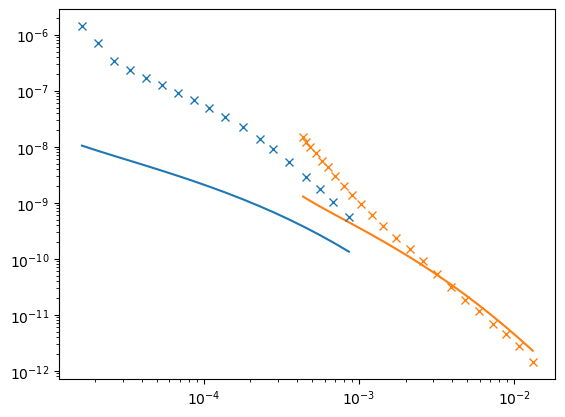

In [210]:
def plot_data(data_obj):
    plt.loglog(LM_times, -data_obj[src_lm, rx_lm])
    plt.loglog(HM_times, -data_obj[src_hm, rx_hm])
    
    plt.loglog(
        LM_times, -data_container[src_lm, rx_lm], color='C0', marker='x', linestyle=""
    )
    plt.loglog(
        HM_times, -data_container[src_hm, rx_hm], color='C1', marker='x', linestyle=""
    )
    
plot_data(data_pre)

### Multiple layers

In [212]:
n_layers = 3
wire_map = maps.Wires(('sigma',n_layers), ('thicknesses', n_layers-1))

In [214]:
sigma_map = exp_map * wire_map.sigma
thick_map = wire_map.thicknesses # exp_map * wire_map.thicknesses # delete exp_map

In [216]:
# let's use the best fitting half-space as our initial model
m_sigma_0_2 = np.full(n_layers, recovered_model[0])  # Already in log-space
m_h_0_2 = np.log(np.full(n_layers-1, 10))
m_0_2 = np.r_[m_sigma_0_2, m_h_0_2]

sim_inv2 = tdem.Simulation1DLayered(srv, sigmaMap=sigma_map, thicknessesMap=thick_map)

In [218]:
sim_inv2.model = m_0_2
sim_inv2.sigma

array([0.15395825, 0.15395825, 0.15395825])

In [220]:
phi_d_2 = L2DataMisfit(data=data_container, simulation=sim_inv2)

# create all of the same components of the inversion problem as before
minimizer2 = opt = optimization.InexactGaussNewton(
    maxIter=10, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)

# again create a reg that has the same input size as the model vector, and then turn it off by setting `beta=0`
empty_reg = regularization.Smallness(discretize.TensorMesh([len(m_0_2)]))
inv_prob_2 = inverse_problem.BaseInvProblem(
    phi_d_2, reg=empty_reg, opt=minimizer2, beta=0.0
)

In [222]:
inv2 = inversion.BaseInversion(inv_prob_2, [])

# Run inversion
recovered_model_2 = inv2.run(m_0_2)


Running inversion with SimPEG v0.22.2
simpeg.InvProblem will set Regularization.reference_model to m0.

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  2.81e+03  0.00e+00  2.81e+03    7.59e+01      0              


/Applications/anaconda3/envs/simpeg-env/lib/python3.9/site-packages/simpeg/maps/_property_maps.py:48: RuntimeWarning: overflow encountered in exp
  return np.exp(mkvc(m))


   1  0.00e+00  2.60e+03  2.29e+00  2.60e+03    2.32e+02      9              
   2  0.00e+00  2.60e+03  2.35e+00  2.60e+03    2.33e+02     13   Skip BFGS  
   3  0.00e+00  2.60e+03  2.44e+00  2.60e+03    2.34e+02     13   Skip BFGS  
   4  0.00e+00  2.60e+03  2.54e+00  2.60e+03    2.35e+02     13   Skip BFGS  
   5  0.00e+00  2.60e+03  2.66e+00  2.60e+03    2.37e+02     13   Skip BFGS  
   6  0.00e+00  2.48e+03  6.45e+00  2.48e+03    1.47e+03      9   Skip BFGS  
   7  0.00e+00  2.46e+03  8.23e+00  2.46e+03    1.71e+03      2              
   8  0.00e+00  2.46e+03  8.23e+00  2.46e+03    1.71e+03     19              
   9  0.00e+00  2.46e+03  8.23e+00  2.46e+03    1.70e+03     19   Skip BFGS  
  10  0.00e+00  2.46e+03  8.23e+00  2.46e+03    1.70e+03     19   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 1.0355e-03 <= tolF*(1+|f0|) = 2.8070e+02
1 : |xc-x_last| = 3.4117e-02 <= tolX*(1+|x0|) = 5.5942e-01
0 : |proj(x-g)-x|    = 1.6960e+03 <= tolG     

In [223]:
data_pre_2 = sim_inv2.make_synthetic_data(recovered_model_2)
sim_inv2.sigma, sim_inv2.thicknesses

(array([6.35197287e+00, 1.33085747e-02, 4.11104959e-03]),
 array([-0.49014435,  2.92804435]))

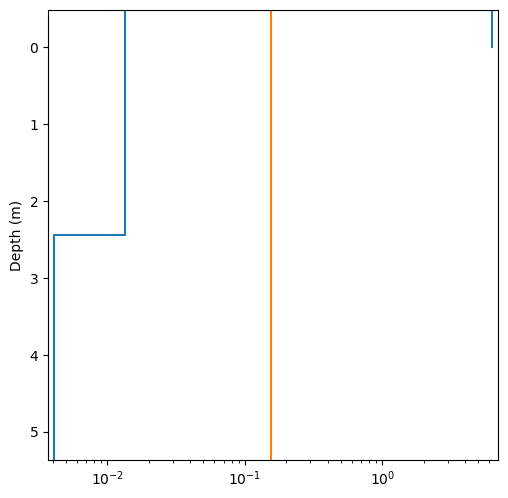

In [224]:
ax = plot_1d_layer_model(sim_inv2.thicknesses, sim_inv2.sigma)
ax.axvline(sim_inv1.sigma, color='C1')
#ax.set_ylim([50, 0])
#ax.set_xlim([1E-2, 1E0]);

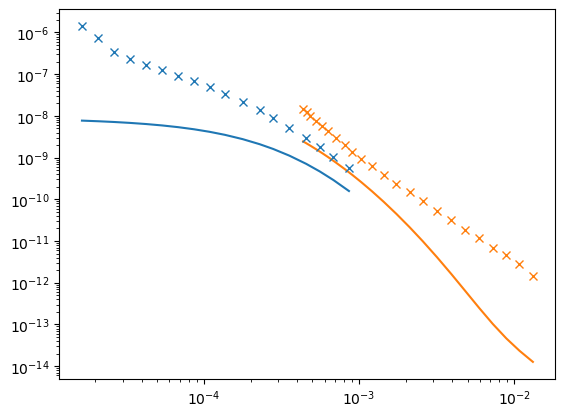

In [230]:
plot_data(data_pre_2)

### Regularized inversion

In [234]:
# (start_size, number_of_cells, expansion_factor)
h = [1, (1.0, 63, 1.05)]
mesh = discretize.TensorMesh([h,])
mesh

TensorMesh: 64 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     64          0.00        434.09      1.00     21.62    1.05

In [235]:
sim_reg = tdem.Simulation1DLayered(srv, sigmaMap=exp_map, thicknesses=mesh.h[0][:-1])

phi_d_reg = L2DataMisfit(data=data_container, simulation=sim_reg)

# This class creates a function that measures the smallness
# and the smoothness of the model.
reg = regularization.WeightedLeastSquares(mesh)

In [256]:
m_0_reg = np.full(mesh.n_cells, recovered_model[0])

In [258]:
# create all of the same components of the inversion problem as before
minimizer_reg = optimization.InexactGaussNewton(
    maxIter=20, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)

inv_prob_3 = inverse_problem.BaseInvProblem(
    phi_d_reg, reg=reg, opt=minimizer_reg #, beta=5 # change beta !
)

In [262]:
# update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=5)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=3)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list_L2 = [starting_beta, beta_schedule, target_misfit]

In [264]:
inv3 = inversion.BaseInversion(inv_prob_3, directives_list_L2)

# Run inversion
recovered_model_3 = inv3.run(m_0_reg)


Running inversion with SimPEG v0.22.2

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.65e-01  2.81e+03  0.00e+00  2.81e+03    6.42e+01      0              
   1  1.65e-01  2.58e+03  4.25e+01  2.59e+03    4.95e+01      3              
   2  1.65e-01  2.50e+03  7.47e+01  2.52e+03    1.35e+02      3              
   3  8.25e-02  2.45e+03  8.80e+01  2.46e+03    1.08e+02      3              
   4  8.25e-02  2.41e+03  2.26e+02  2.43e+03    2.06e+02      3              
   5  8.25e-02  2.37e+03  2.61e+02  2.39e+03    1.13e+02      3         

(0.001, 1.0)

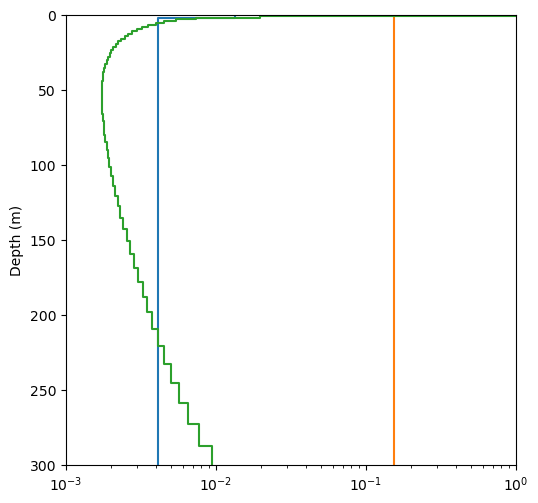

In [265]:
data_pre_3 = sim_reg.make_synthetic_data(recovered_model_3)
ax = plot_1d_layer_model(sim_inv2.thicknesses, sim_inv2.sigma)
ax.axvline(sim_inv1.sigma, color='C1')
plot_1d_layer_model(sim_reg.thicknesses, sim_reg.sigma, ax=ax, color='C2')
ax.set_ylim([300, 0])
ax.set_xlim([1E-3, 1E0])

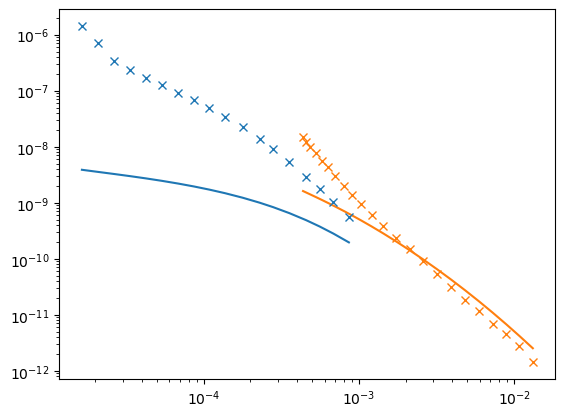

In [244]:
plot_data(data_pre_3)

In [245]:
beta_cooler = directives.BetaSchedule(coolingFactor=5, coolingRate=2)

In [246]:
save_dict = directives.SaveOutputDictEveryIteration()

In [247]:
# create all of the same components of the inversion problem as before
minimizer_reg = opt = optimization.InexactGaussNewton(
    maxIter=20, maxIterLS=20, maxIterCG=100, tolCG=1e-5
)

inv_prob_4 = inverse_problem.BaseInvProblem(
    phi_d_reg, reg=reg, opt=minimizer_reg, beta=10000
)

inv4 = inversion.BaseInversion(inv_prob_4, [save_dict, beta_cooler])

# Run inversion
recovered_model_4 = inv4.run(m_0_reg)


Running inversion with SimPEG v0.22.2

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+04  2.81e+03  0.00e+00  2.81e+03    6.42e+01      0              
   1  1.00e+04  2.81e+03  5.70e-06  2.81e+03    2.37e-02      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 5.7058e-02 <= tolF*(1+|f0|) = 2.8070e+02
1 : |xc-x_last| = 1.9852e-03 <= tolX*(1+|x0|) = 1.5969e+00
1 : |proj(x-g)-x|    = 2.3722e-02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 2.3722e-02 <= 1e3*eps       = 1.0000e-02
0 : 

In [ ]:
n_iter = save_dict.opt.iter
phi_ds = [save_dict.outDict[i]['phi_d'] for i in range(1, n_iter)]
phi_ms = [save_dict.outDict[i]['phi_m'] for i in range(1, n_iter)]
betas =  [save_dict.outDict[i]['beta'] for i in range(1, n_iter)]

In [ ]:

# this is an L-curvey plot
plt.loglog(phi_ms, phi_ds)
plt.loglog(phi_ms[14], phi_ds[14], marker='*', markersize=10)

(0.001, 1.0)

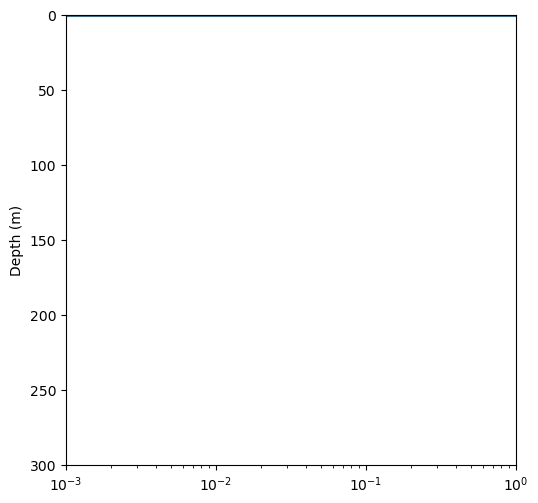

In [452]:
m_final = save_dict.outDict[14]['m']
d_final = sim_reg.make_synthetic_data(m_final)
ax = plot_1d_layer_model(sim_reg.thicknesses, exp_map * m_final)
plot_1d_layer_model(sim_inv2.thicknesses, sim_inv2.sigma, ax=ax)
ax.set_ylim([300, 0])
ax.set_xlim([1E-3, 1E0])

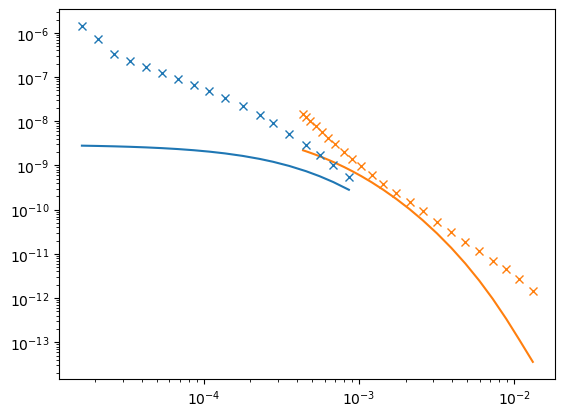

In [454]:
plot_data(d_final)